In [6]:
import os
from tasrif.processing_pipeline import SequenceOperator, ComposeOperator, MapIterableOperator
from tasrif.data_readers.fitbit_interday_dataset import FitbitInterdayDataset
from tasrif.processing_pipeline.pandas import ConvertToDatetimeOperator, SetIndexOperator, ConcatOperator, MergeOperator, \
AsTypeOperator, DropFeaturesOperator
from tasrif.processing_pipeline.custom import CreateFeatureOperator, AggregateOperator, FlattenOperator

In [13]:
interday_folder_path = os.environ.get('FITBIT_INTERDAY_PATH', '/mnt/data/fitbit-data/')
interday_folder_path

'/Users/ahmad/mnt/data/fitbit-data/'

In [14]:
pipeline = SequenceOperator([
    FitbitInterdayDataset(interday_folder_path, table_name="Sleep"),
    ConvertToDatetimeOperator(feature_names=['Start Time', 'End Time'],
                                infer_datetime_format=True),    
    CreateFeatureOperator(
        feature_name="Date",
        feature_creator=lambda df: df['End Time'].date()),
    AggregateOperator(groupby_feature_names="Date",
                        aggregation_definition={
                            'Minutes Asleep': 'sum',
                            'Minutes Awake': 'sum',
                            'Number of Awakenings': 'sum',
                            'Time in Bed': 'sum',
                            'Minutes REM Sleep': 'sum',
                            'Minutes Light Sleep': 'sum',
                            'Minutes Deep Sleep': 'sum'
                        }),
    AsTypeOperator({'Date':'str'}),
    SetIndexOperator('Date')
])

In [15]:
df = pipeline.process()
df

[            Minutes Asleep_sum  Minutes Awake_sum  Number of Awakenings_sum  \
 Date                                                                          
 2019-06-01                 436                 40                        25   
 2019-06-02                 291                 21                         3   
 2019-06-03                 198                 18                         1   
 2019-06-04                 220                 26                        10   
 2019-06-05                 745                 87                        40   
 2019-06-06                 456                 58                        29   
 2019-06-07                 534                 76                        27   
 2019-06-08                 503                 62                        31   
 2019-06-09                 394                 55                        17   
 2019-06-10                 399                 70                        18   
 2019-06-11                 380         

In [16]:
import tasrif.yaml_parser as yaml_parser
import yaml
    

In [17]:
with open("example.yaml", "r") as stream:
    try:
#         print(json.dumps(yaml.safe_load(stream), indent=4, sort_keys=True))
        p = yaml_parser.from_yaml(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [18]:
p

,Calories Burned,Steps,Distance,Minutes Sedentary,Minutes Asleep_sum,Minutes Non Sedentary
Calories Burned,1.000000,0.896269,0.896551,0.143744,-0.459172,0.087925
Steps,0.896269,1.000000,0.998784,0.217899,-0.417167,-0.037131
Distance,0.896551,0.998784,1.000000,0.199556,-0.406140,-0.019284
Minutes Sedentary,0.143744,0.217899,0.199556,1.000000,-0.714127,-0.903897
Minutes Asleep_sum,-0.459172,-0.417167,-0.406140,-0.714127,1.000000,0.346064
Minutes Non Sedentary,0.087925,-0.037131,-0.019284,-0.903897,0.346064,1.000000


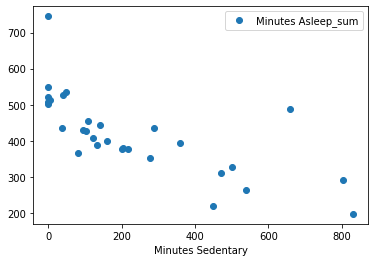

In [19]:
df = p.process()
df[0].plot(x='Minutes Sedentary', y='Minutes Asleep_sum', style = 'o')
df[0].corr()

In [20]:
pipeline = SequenceOperator([ComposeOperator([SequenceOperator([
    FitbitInterdayDataset(interday_folder_path, table_name="Activities"),
    ConvertToDatetimeOperator(feature_names=['Date'],
                              infer_datetime_format=True),
    AsTypeOperator({'Date':'str'}),
    SetIndexOperator('Date')
]),
SequenceOperator([
    FitbitInterdayDataset(interday_folder_path, table_name="Sleep"),
    ConvertToDatetimeOperator(feature_names=['Start Time', 'End Time'],
                                infer_datetime_format=True),
    CreateFeatureOperator(
        feature_name="Date",
        feature_creator=lambda df: df['End Time'].date()),
    AggregateOperator(groupby_feature_names="Date",
                        aggregation_definition={
                            'Minutes Asleep': 'sum',
                            'Minutes Awake': 'sum',
                            'Number of Awakenings': 'sum',
                            'Time in Bed': 'sum',
                            'Minutes REM Sleep': 'sum',
                            'Minutes Light Sleep': 'sum',
                            'Minutes Deep Sleep': 'sum'
                        }),
    AsTypeOperator({'Date':'str'}),
    SetIndexOperator('Date')
])]),
FlattenOperator(),
MergeOperator(on='Date', how='inner'),
CreateFeatureOperator(feature_name='Minutes Non Sedentary',
                      feature_creator=lambda df: 1440 - df['Minutes Sedentary'] - df['Minutes Asleep_sum'])]);

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Minutes Asleep_sum,Minutes Awake_sum,Number of Awakenings_sum,Time in Bed_sum,Minutes REM Sleep_sum,Minutes Light Sleep_sum,Minutes Deep Sleep_sum,Minutes Non Sedentary
Calories Burned,1.000000,0.896269,0.896551,NaN,0.143744,0.080880,0.754782,0.873001,0.997286,-0.459172,-0.124066,-0.281365,-0.425525,-0.255232,-0.264864,-0.148475,0.087925
Steps,0.896269,1.000000,0.998784,NaN,0.217899,0.056670,0.550990,0.813472,0.890443,-0.417167,-0.220248,-0.315267,-0.396983,-0.290816,-0.323696,-0.249528,-0.037131
Distance,0.896551,0.998784,1.000000,NaN,0.199556,0.055742,0.550314,0.815716,0.891226,-0.406140,-0.206834,-0.299170,-0.385269,-0.270584,-0.313036,-0.231911,-0.019284
Floors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minutes Sedentary,0.143744,0.217899,0.199556,NaN,1.000000,-0.001175,-0.027815,0.103241,0.118198,-0.714127,-0.870361,-0.882409,-0.758067,-0.899523,-0.930338,-0.863696,-0.903897
Minutes Lightly Active,0.080880,0.056670,0.055742,NaN,-0.001175,1.000000,-0.193235,-0.357998,0.114773,-0.117504,-0.100292,0.043293,-0.133825,0.043224,0.124761,0.114494,0.073377
Minutes Fairly Active,0.754782,0.550990,0.550314,NaN,-0.027815,-0.193235,1.000000,0.706921,0.763563,-0.297244,0.070396,-0.181270,-0.249781,-0.219937,-0.067257,-0.117360,0.218913
Minutes Very Active,0.873001,0.813472,0.815716,NaN,0.103241,-0.357998,0.706921,1.000000,0.859969,-0.354002,-0.071966,-0.268141,-0.316574,-0.220002,-0.286779,-0.154868,0.077945
Activity Calories,0.997286,0.890443,0.891226,NaN,0.118198,0.114773,0.763563,0.859969,1.000000,-0.442273,-0.102809,-0.265643,-0.408209,-0.239338,-0.236638,-0.132192,0.111837
Minutes Asleep_sum,-0.459172,-0.417167,-0.406140,NaN,-0.714127,-0.117504,-0.297244,-0.354002,-0.442273,1.000000,0.728866,0.785575,0.994349,0.766603,0.696350,0.684324,0.346064


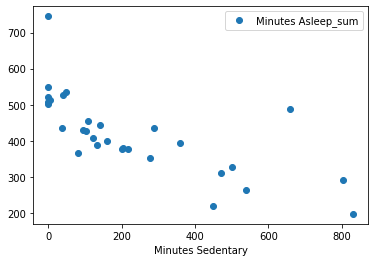

In [21]:
df = pipeline.process()
df[0].plot(x='Minutes Sedentary', y='Minutes Asleep_sum', style = 'o')
df[0].corr()

In [ ]:

do = DropFeaturesOperator(feature_names=['Floors'])